<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
"""Train an CNN to classify images from the MNIST database."""
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [17]:
# number of subprocesses to use for data loading
num_workers = 0
batch_size = 20
valid_size = 0.2

# convert data to torch.FloatTensor
transforms = transforms.ToTensor()
train_data = datasets.MNIST(
    root="train_data_MNIST", train=True, download=True, transform=transforms
)
test_data = datasets.MNIST(
    root="test_data_MNIST", train=False, download=True, transform=transforms
)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

(20, 1, 28, 28)


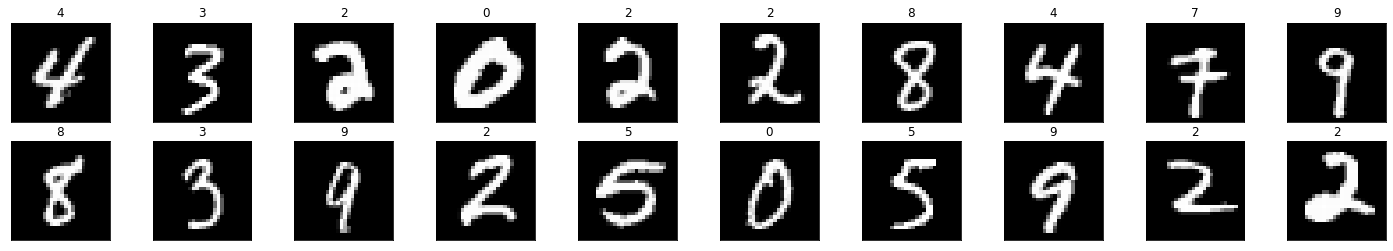

In [18]:
# visualize a batch of training data
import matplotlib.pyplot as plt
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title(str(labels[idx].item()))
    img = np.squeeze(images[1])
plt.show()

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [20]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [22]:
import time


tic = time.time()
n_epochs = 10
train_losses, valid_losses = [], []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
         
    # validate the model    
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
toc = time.time()
print("Time:", 1000*(toc-tic), "ms")

Epoch: 1 	Training Loss: 0.004816 	Validation Loss: 0.003305
Epoch: 2 	Training Loss: 0.004135 	Validation Loss: 0.002809
Epoch: 3 	Training Loss: 0.003679 	Validation Loss: 0.002687
Epoch: 4 	Training Loss: 0.003285 	Validation Loss: 0.002352
Epoch: 5 	Training Loss: 0.002960 	Validation Loss: 0.002449
Epoch: 6 	Training Loss: 0.002727 	Validation Loss: 0.002106
Epoch: 7 	Training Loss: 0.002547 	Validation Loss: 0.001998
Epoch: 8 	Training Loss: 0.002380 	Validation Loss: 0.001988
Epoch: 9 	Training Loss: 0.002142 	Validation Loss: 0.001756
Epoch: 10 	Training Loss: 0.002038 	Validation Loss: 0.001843
Time: 456773.5414505005 ms


In [23]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.001480

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1129/1135)
Test Accuracy of     2: 98% (1018/1032)
Test Accuracy of     3: 99% (1005/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 98% (941/958)
Test Accuracy of     7: 98% (1009/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 99% (999/1009)

Test Accuracy (Overall): 98% (9892/10000)
